In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 1.3MB/s 
     |████████████████████████████████| 3.1MB 34.4MB/s 
     |████████████████████████████████| 501kB 48.6MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-08-13 11:44:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2019-08-13 11:44:53 (2.64 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



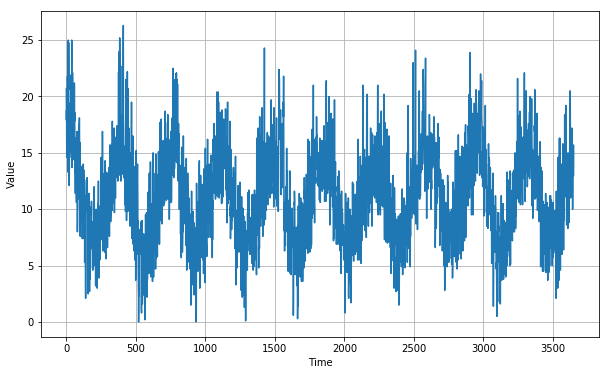

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for step, row in enumerate(reader):
        temps.append(float(row[1]))
        time_step.append(step)

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 548ms/step - loss: 11.7285 - mae: 12.2389
Epoch 2/100
10/10 [==============================] - 3s 288ms/step - loss: 11.0807 - mae: 11.6005
Epoch 3/100
10/10 [==============================] - 3s 291ms/step - loss: 10.0765 - mae: 10.6028
Epoch 4/100
10/10 [==============================] - 3s 291ms/step - loss: 8.8452 - mae: 9.3745
Epoch 5/100
10/10 [==============================] - 3s 292ms/step - loss: 7.4956 - mae: 8.0221
Epoch 6/100
10/10 [==============================] - 3s 288ms/step - loss: 6.1795 - mae: 6.6966
Epoch 7/100
10/10 [==============================] - 3s 291ms/step - loss: 5.0770 - mae: 5.5790
Epoch 8/100
10/10 [==============================] - 3s 288ms/step - loss: 4.3234 - mae: 4.8123
Epoch 9/100
10/10 [==============================] - 3s 293ms/step - loss: 3.9108 - mae: 4.3913
Epoch 10/100
10/10 [========

[1e-08, 0.0001, 0, 60]

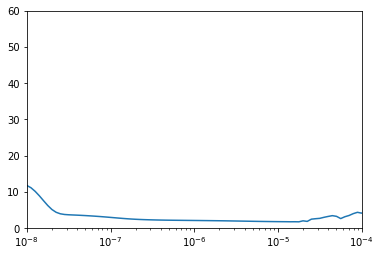

In [17]:
# Plot learning rate history vs loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
# Train with the new learning rate

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(
    lr=1e-5,
    momentum=0.9
)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
history = model.fit(train_set,epochs=100)


Epoch 1/100
25/25 [==============================] - 6s 249ms/step - loss: 8.7152 - mae: 9.3630
Epoch 2/100
25/25 [==============================] - 4s 148ms/step - loss: 2.3685 - mae: 2.8359
Epoch 3/100
25/25 [==============================] - 4s 148ms/step - loss: 1.9109 - mae: 2.3641
Epoch 4/100
25/25 [==============================] - 4s 147ms/step - loss: 1.8368 - mae: 2.2890
Epoch 5/100
25/25 [==============================] - 4s 146ms/step - loss: 1.7975 - mae: 2.2493
Epoch 6/100
25/25 [==============================] - 4s 145ms/step - loss: 1.7647 - mae: 2.2159
Epoch 7/100
25/25 [==============================] - 4s 145ms/step - loss: 1.7409 - mae: 2.1916
Epoch 8/100
25/25 [==============================] - 4s 144ms/step - loss: 1.7228 - mae: 2.1730
Epoch 9/100
25/25 [==============================] - 4s 143ms/step - loss: 1.7092 - mae: 2.1591
Epoch 10/100
25/25 [==============================] - 4s 146ms/step - loss: 1.6987 - mae: 2.1481
Epoch 11/100
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

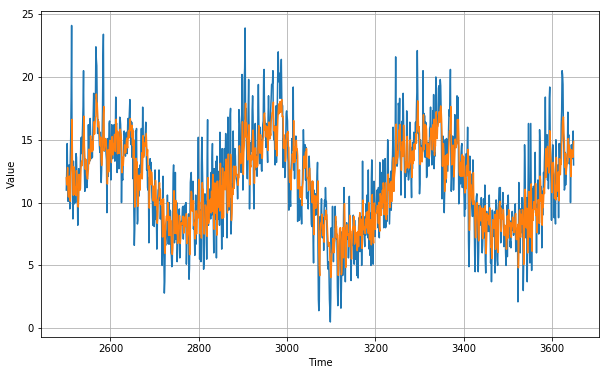

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8149811

In [22]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.973359 11.412613 11.994193 ... 13.608188 13.611195 14.865404]
